In [33]:
import matplotlib
matplotlib.rc('pdf', fonttype=42)
import matplotlib.pyplot as plt
import glob
import os
import re
import pandas as pd
import numpy as np 
import seaborn as sns
from scipy.sparse import coo_matrix, hstack, vstack
from collections import defaultdict

from ALLCools.clustering import tsne, binarize_matrix
from ALLCools.plot import *
from ALLCools.integration import SeuratIntegration

import scanpy as sc
import anndata
from harmonypy import run_harmony

In [2]:
mC_adata = anndata.read_h5ad("/gale/netapp/DoD/wenliang/projects/01.HIV/05.clustering/HIV_All.TSNE.HM.Annotation.h5ad")

In [3]:
bin_df = mC_adata.var
bin_df['binID'] = bin_df.index
transfer_id = dict()
for i, row in bin_df.iterrows():
    atac_id = f'{row.chrom}:{row.start}-{row.end}'
    transfer_id[atac_id] = row.binID

In [4]:
h5ad_files = glob.glob("hiv*.h5ad")
h5ad_files = [x for x in h5ad_files if 'lsi' not in x and 'final' not in x]

In [19]:
adata_list = list()
for h5file in h5ad_files:
    atac_adata = anndata.read_h5ad(h5file)
    atac_adata.var_names = [transfer_id[x] if x in transfer_id else x for x in atac_adata.var_names]
    use_var = mC_adata.var_names.intersection(atac_adata.var_names)
    mC_adata._inplace_subset_var(use_var)
    atac_adata._inplace_subset_var(use_var)
    binarize_matrix(atac_adata, cutoff=1)
    adata_list.append(atac_adata)

In [100]:
var_bed = pd.DataFrame({'chrom': [x.split("_")[0] for x in atac_adata.var.index], 'start': [int(x.split("_")[1]) * 5000 for x in atac_adata.var.index],
                       'end' :[(int(x.split("_")[1])+1) * 5000 for x in atac_adata.var.index]}, index=atac_adata.var.index)

In [124]:
target = var_bed[(var_bed['chrom']=='chr13') & (var_bed['start']>=41500000) & (var_bed['end']<=42100000)]

In [49]:
atac_data = anndata.AnnData(vstack([x.X for x in adata_list]), obs=pd.concat([x.obs for x in adata_list]), var=adata_list[0].var)

/tmp/ipykernel_2161857/1985924877.py:1: FutureWarning: X.dtype being converted to np.float32 from int8. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  atac_data = anndata.AnnData(vstack([x.X for x in adata_list]), obs=pd.concat([x.obs for x in adata_list]), var=adata_list[0].var)


In [8]:
cond_cell_mC = dict()
for (cond, cell), group_df in mC_adata.obs.groupby(['condition', 'annotation']):
    group_adata = mC_adata[(mC_adata.obs['condition']==cond) & (mC_adata.obs['annotation']==cell)]
    group_adata_df = group_adata.to_df()
    cond_cell_mC[f'{cond}_{cell}'] = group_adata_df.mean()
cond_cell_mC_df = pd.DataFrame.from_dict(cond_cell_mC, orient='index')

In [94]:
group_adata[]

View of AnnData object with n_obs × n_vars = 1294 × 497527
    obs: 'tsse', 'n_fragment', 'frac_dup', 'frac_mito', 'annotation', 'sample_cluster', 'group_cluster'
    var: 'selected'

In [21]:
metadata = pd.read_csv("All_sample_finalATAC.metadata.csv")
id2group_cluster = dict(zip(["_".join(x.split("_")[-2:]) for x in metadata['cell']], metadata['group_cluster']))

In [23]:
atac_data.obs['group_cluster'] = [id2group_cluster[x] for x in atac_data.obs.index]

/tmp/ipykernel_2160451/754466100.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  atac_data.obs['group_cluster'] = [id2group_cluster[x] for x in atac_data.obs.index]


In [9]:
atac_data = atac_adata

In [52]:
group_activity = dict()
for group, group_df in atac_data.obs.groupby('group_cluster'):
    group_adata = atac_data[atac_data.obs['group_cluster']==group]
    group_adata_df = group_adata.to_df()
    group_activity[group] = group_adata_df.mean()
group_activity_df = pd.DataFrame.from_dict(group_activity, orient='index')

In [85]:
cond_cell_mC_df.index = [f'mC_{"_".join(x.split("_")[-2:])}' for x in cond_cell_mC_df.index]
group_activity_df.index = [f'ATAC_{"_".join(x.split("_")[-2:])}' for x in group_activity_df.index]

merge_5kb_mC_ATAC = pd.concat([cond_cell_mC_df, group_activity_df])
corr_df = merge_5kb_mC_ATAC.T.corr()

In [86]:
select_index = [x for x in corr_df.index if x.startswith('mC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]
select_columns = [x for x in corr_df.columns if x.startswith('ATAC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]

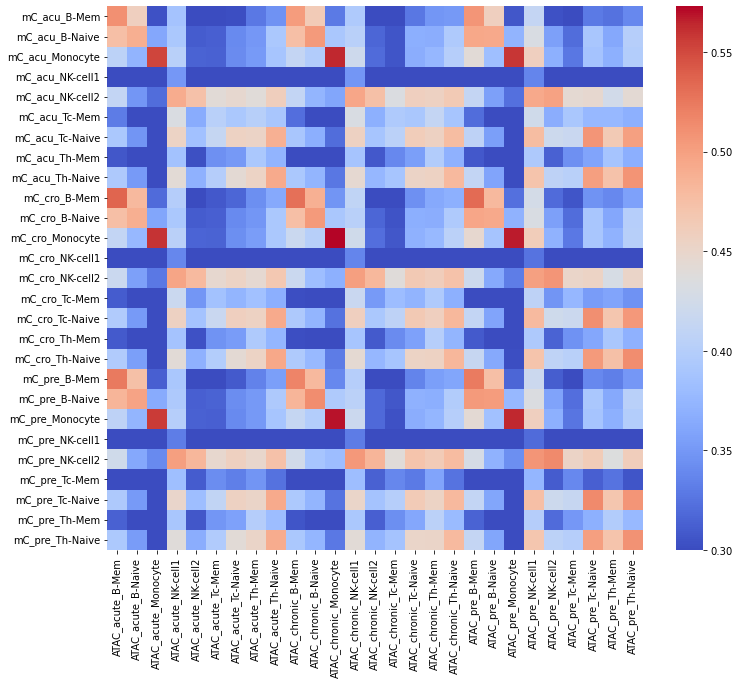

In [89]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(corr_df.loc[select_index, select_columns], cmap='coolwarm', vmin=0.3)
plt.savefig("mC_ATAC_corr.pdf")

# Read 5kb bin MCDS

In [20]:
from ALLCools.mcds import MCDS

In [21]:
mcds = MCDS.open("/gale/netapp/DoD/wenliang/projects/01.HIV/19.mergeCond/MCDS/HIV_bulk", var_dim='chrom5k')

In [37]:
mcds.add_mc_rate(var_dim='chrom5k', normalize_per_cell=False, clip_norm_value=10)
chrom5k_mC = mcds['chrom5k_da_frac'].squeeze().to_pandas()

/gale/netapp/DoD/wenliang/bin/miniconda3_4.9.2/envs/echo/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


In [111]:
chrom5k_mC.index = [f'mC_{"_".join(x.split("_")[-2:])}' for x in chrom5k_mC.index]
group_activity_df.index = [f'ATAC_{"_".join(x.split("_")[-2:])}' for x in group_activity_df.index]

merge_5kb_mC_ATAC = pd.concat([chrom5k_mC, group_activity_df])
corr_df = merge_5kb_mC_ATAC[target.index].T.corr(method='spearman')

In [112]:
select_index = [x for x in corr_df.index if x.startswith('mC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]
select_columns = [x for x in corr_df.columns if x.startswith('ATAC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]

In [125]:
mc_target = merge_5kb_mC_ATAC.loc[[x for x in merge_5kb_mC_ATAC.index if x.startswith('mC')],target.index]
atac_target = merge_5kb_mC_ATAC.loc[[x for x in merge_5kb_mC_ATAC.index if x.startswith('ATAC')],target.index]

<AxesSubplot:>

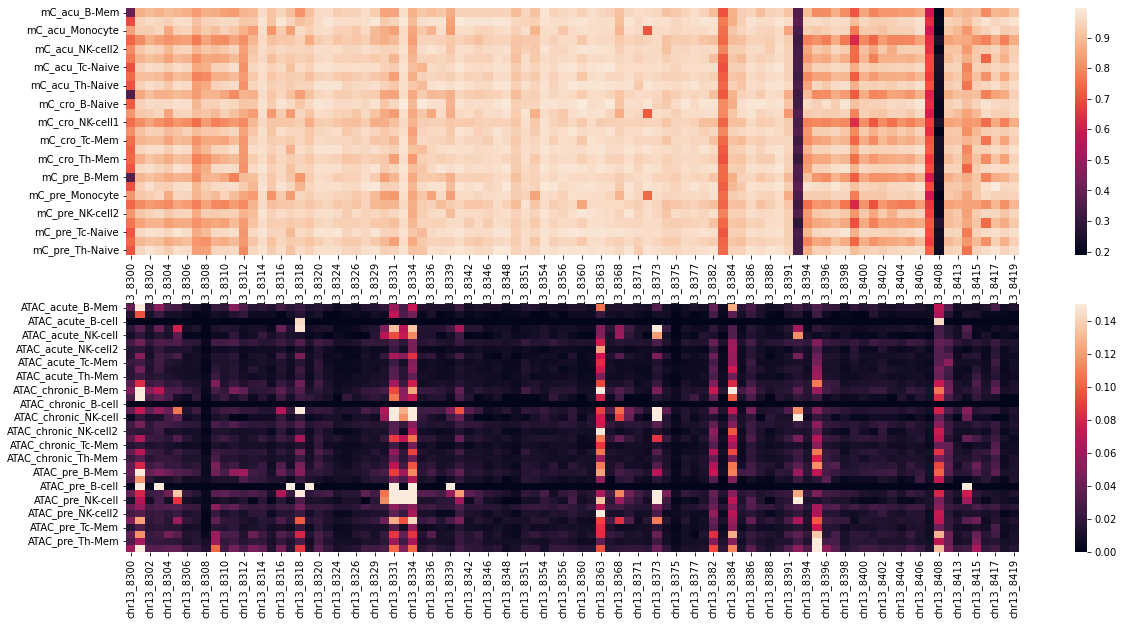

In [126]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
sns.heatmap(mc_target, ax=ax[0])
sns.heatmap(atac_target, ax=ax[1], vmax=0.15)

/gale/netapp/DoD/wenliang/bin/miniconda3_4.9.2/envs/echo/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='mC_acu_B-Mem', ylabel='ATAC_acute_B-Mem'>

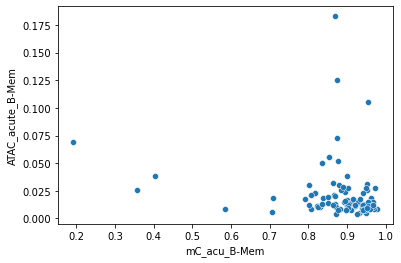

In [127]:
sns.scatterplot(mc_target.loc['mC_acu_B-Mem'], atac_target.loc['ATAC_acute_B-Mem'])

<AxesSubplot:>

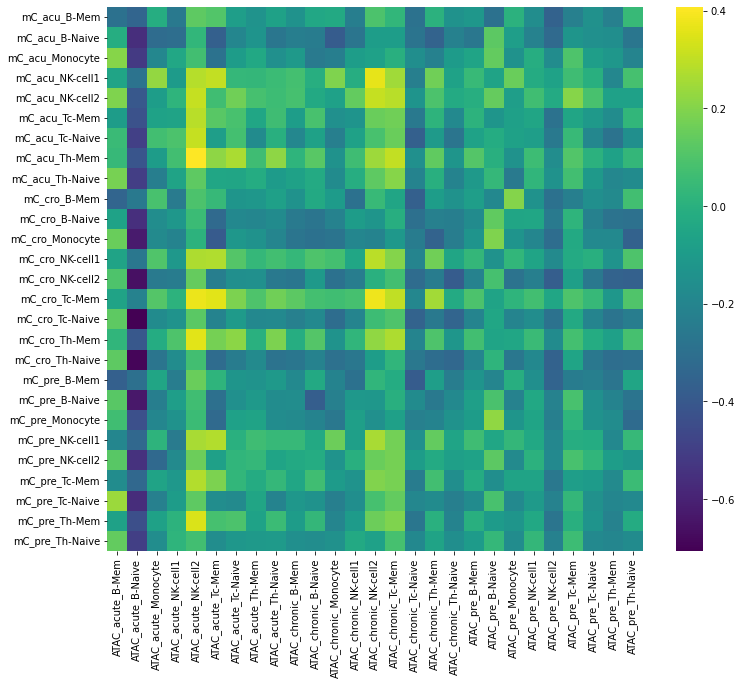

In [113]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(corr_df.loc[select_index, select_columns], cmap='viridis')

In [90]:
cond_cell_mC_df.index = [f'mC_{"_".join(x.split("_")[-2:])}' for x in cond_cell_mC_df.index]
chrom5k_mC.index = [f'ATAC_{"_".join(x.split("_")[-2:])}' for x in chrom5k_mC.index]

hypo_score_mC = pd.concat([cond_cell_mC_df, chrom5k_mC])
corr_df = hypo_score_mC.T.corr()

In [91]:
select_index = [x for x in corr_df.index if x.startswith('mC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]
select_columns = [x for x in corr_df.columns if x.startswith('ATAC') and 'B-cell' not in x and 'Other-cell' not in x and 
               not x.endswith('NK-cell')]

<AxesSubplot:>

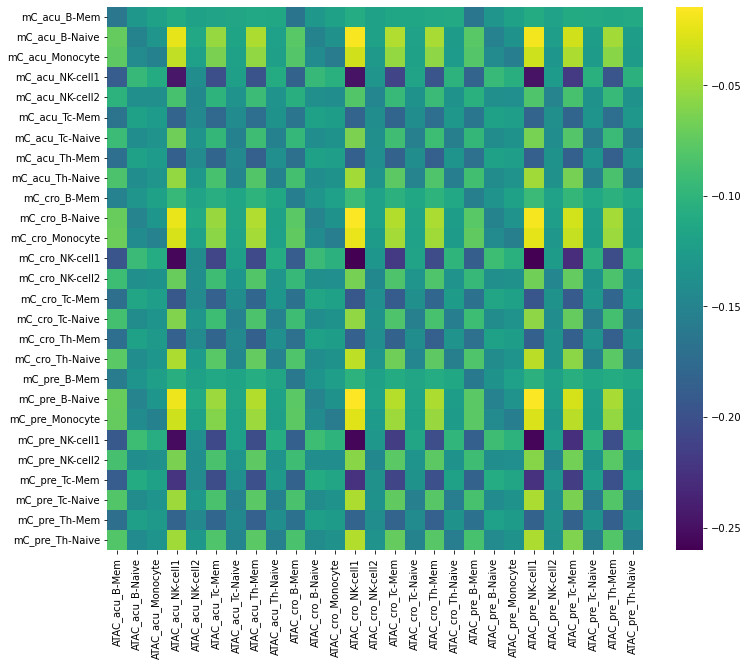

In [92]:
fig, ax = plt.subplots(1,1,figsize=(12,10))
sns.heatmap(corr_df.loc[select_index, select_columns], cmap='viridis')